In [1]:
import numpy as np
import emoji
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
#Reading the Embeddings from 'glove.6B.50d.txt' file

f=open("glove.6B.50d.txt", "r", encoding='utf8')
word_to_vec_map={}
words=set()

for line in f:
    line_list=line.strip().split()
    words.add(line_list[0])
    word_to_vec_map[line_list[0]]=np.array( line_list[1:] , dtype=np.float)
index_to_word={k:v for k,v in enumerate(sorted(words), start=1)}
word_to_index={v:k for k,v in enumerate(sorted(words), start=1)}

In [3]:
#Analysing the Vocabulary.
vocab_size=len(word_to_vec_map.keys())
print("Vocab is of size : {}".format(vocab_size))

Embeddings_size=word_to_vec_map['father'].shape
print("Size of Embeddings : {}".format(Embeddings_size))

Vocab is of size : 400000
Size of Embeddings : (50,)


In [4]:
#Reading the data from the files.
df_train=pd.read_csv('./data/train_emoji.csv')
df_test=pd.read_csv("./data/test_emoji.csv")


In [5]:
#Analysing the data
x_train=np.array(df_train['sentence'])
y_train=np.array(df_train['label'])

x_test=np.array(df_test['sentence'])
y_test=np.array(df_test['label'])


print("Shape of x_train: {}".format(x_train.shape))
print("Shape of y_train: {}".format(y_train.shape))

print("Shape of x_test: {}".format(x_test.shape))
print("Shape of y_tesr: {}".format(y_test.shape))

Shape of x_train: (132,)
Shape of y_train: (132,)
Shape of x_test: (56,)
Shape of y_tesr: (56,)


In [6]:
emoji_dictionary = {0: "\u2764\uFE0F",    # heart 
                    1: ":baseball:",
                    2: ":smile:",
                    3: ":disappointed:",
                    4: ":fork_and_knife:"}

def label_to_emoji(label):
    """
    This takes the label from {0,1,2,3,4} and returns the corresponding emoji.
    """
    
    label_code=emoji_dictionary[label]
    a=emoji.emojize(label_code, use_aliases=True)
    return a

In [7]:
#Getting the glimse of the data
for i in range(10):
    print(x_train[i], y_train[i], label_to_emoji(y_train[i]))

never talk to me again 3 😞
I am proud of your achievements 2 😄
It is the worst day in my life 3 😞
Miss you so much 0 ❤️
food is life 4 🍴
I love you mum 0 ❤️
Stop saying bullshit 3 😞
congratulations on your acceptance 2 😄
The assignment is too long  3 😞
I want to go play 1 ⚾


In [8]:
#let's convert the labels into one-hot encodings.

def labels_to_oh(Y, classes=5):
    """
    This function converts the labels into one-hot encodings.
    Arguments:
        Y: Array of shape(m,)
        classes: int
    Returns:
        one_hot: Array of shape(classes, m)
    """
    one_hot=np.zeros((classes,Y.shape[0]))
    m_list=np.arange(Y.shape[0])
    one_hot[Y,m_list ]=1
    return one_hot

In [9]:
#Let's check the above function:
idx = 59  #Feel free to play with this
print("Sentence '{}' has label index {}  which is emoji {}".format( x_train[idx], y_train[idx], label_to_emoji(y_train[idx]) ) )
print("Label index {} in one-hot encoding format is: \n {}".format( y_train[idx], labels_to_oh(np.array([ y_train[idx] ]), 5) ))

Sentence 'You are incredibly intelligent and talented' has label index 2  which is emoji 😄
Label index 2 in one-hot encoding format is: 
 [[0.]
 [0.]
 [1.]
 [0.]
 [0.]]


Model 1

In [10]:
def avg_fun(sentence):
    """
    This function takes a single sentence and returns the average vector of it's words embeddings.
    Arguments: 
        sentence: a string of single sentence
    
    Returns:
        arr: A average vector , of shape(50,)
    """
    
    sentence_list=sentence.split()
    arr=np.zeros( word_to_vec_map['father'].shape )
    for i in range( len(sentence_list) ):
        arr+=word_to_vec_map[sentence_list[i].lower()]
    arr=arr/len(sentence_list)
    return arr

In [11]:
# checking the above function
avg = avg_fun("Machine Leaning")
print("avg = \n", avg)

avg = 
 [-0.5081    -0.49981    0.910065  -0.417435  -0.0855345  0.1721485
 -0.221605  -0.2937245 -0.570465  -0.02338   -0.306108  -0.84905
 -0.201511   0.63919   -0.91403   -0.281875  -0.403532   0.366115
  0.089415  -0.633365   0.0429     0.145705   0.0418234  0.16978
  0.1502575 -1.2991    -0.61849    0.47496    0.34654   -0.40018
  2.1238    -0.3645935 -0.566265  -0.021425  -0.695707   0.02204
  0.05728    0.4932     0.199505   0.049545   0.5472715  0.075176
 -0.539305   0.467965   0.079155  -0.357905  -0.10787   -0.36209
  0.44183   -0.081715 ]


In [12]:
#Our usual softmax
def softmax(x):
    temp=np.exp(x)
    return temp/np.sum(temp, axis=0, keepdims=True)


In [13]:
#Now comes the first real game

def model(x_train, y_train, learning_rate=0.01, num_of_iters=80000):
    """
    This function trains our model for sentiment-classification using avg_fun function and neural-network
    Arguments:
        x_train: X-training-set , having shape (m,) .Here ,m=132
        y_train: y-training-set , having shape (m,)
    
    Returns:
        W: Parameter of the model, having shape (5,50)
        b: Parameter of the model, having shape (5,1)
        loss_list: List containing the loss over consecutive epochs, useful for finding num_of_iters
    """
    
    y_train_final=labels_to_oh(y_train) # y_train_final : shape=(5,132)
   
    
    x_train_final=np.array( [avg_fun(i) for i in x_train] ).T  # x_train_final:shape(50,132)
    m=x_train_final.shape[1] # no. of training examples
    
    n_0=x_train_final.shape[0]
    n_1=y_train_final.shape[0]
    
    #Initializing my parameters
    W=np.random.randn(n_1,n_0) / np.sqrt(n_0)
    b=np.zeros( (n_1,1) )
    
    loss_list=[]
    for epoch in range( num_of_iters):
        
        #forward Pass
        A=softmax(np.dot(W, x_train_final)+b)
        
        loss=-np.sum( ( y_train_final*np.log(A) ))
        loss_list.append(loss)
        
        #Backward Pass
        dZ=A-y_train_final
        dW=( np.dot(dZ, x_train_final.T) ) /m
        db=( np.sum( dZ, axis=1, keepdims=True ) ) /m
        
        #updating the parameters
        W=W-learning_rate*dW        
        b=b-learning_rate*db
        
    return W,b, loss_list
        
    

In [14]:
W,b, loss_list =model(x_train, y_train)

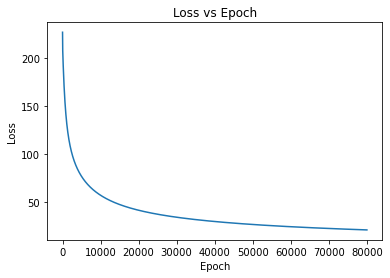

In [15]:
plt.plot(loss_list)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.show()

In [16]:
def emojifier_model1(sentence, W,b):
    """
    This function returns the appropriate emoji to the given sentence.
    Arguments:
        sentence: A string
        W: Trained parameter of the above model
        b: Trained parameter of the above model
    
    Returns:
        emo : A emoji
    """
    avg_vec=avg_fun(sentence)
    avg_vec=avg_vec.reshape(50,1)
    A = softmax(np.dot(W, avg_vec)+b)
    
    label=np.argmax(A)
    
    emo=label_to_emoji(label)
    print(sentence, "--->", emo)
    

In [17]:
emojifier_model1("i am in love", W, b) 
emojifier_model1("i love you", W, b) 
emojifier_model1("I play", W, b) 
emojifier_model1("i am in good mood", W, b) 
emojifier_model1("i am not in good mood", W, b) 

i am in love ---> 😄
i love you ---> ❤️
I play ---> ⚾
i am in good mood ---> 😄
i am not in good mood ---> 😄


In [18]:
def prediction_analysis( X, Y, W, b, word_to_vec_map ):
    """
    Given the X set(Arr of sentences) and Y set(Arr of Labels) , this computes the prediction over 
    all the set and calculates the accuracy.
    """
    
    X_final=np.array( [avg_fun(i) for i in X] ).T #shape(50,m)
    m=X.shape[0]
    
    A=softmax(np.dot(W, X_final)+b)
    pred=np.argmax(A, axis=0)
    
    print("Accuracy: "  + str(np.mean( (pred[:] == Y[:]) )))
    return pred
    

In [19]:
print("Training set:")
pred_train = prediction_analysis(x_train, y_train, W, b, word_to_vec_map)
print("----------------")
print('Test set:')
pred_test = prediction_analysis(x_test, y_test, W, b, word_to_vec_map)

Training set:
Accuracy: 0.9848484848484849
----------------
Test set:
Accuracy: 0.8928571428571429


Model2

In [20]:
import tensorflow as tf

In [21]:
#Finding the maximum length for setting T_x in the model.
max_len= len( max(x_train, key=len).split() )

In [22]:
def sentences_to_indicies(X, word_to_index, max_len):
    """
    This function takes the sentences and converts them into array of indices.
    Arguments:
        X: Dataset, of size(m,)
        word_to_index: Dictionary of word ---> index
        max_len: Int, having value equal to max. length of sentence out of sentences. 
        
    Returns:
        mat: Array of indices, shape:(m,max_len)
1    """ 
    
    m=X.shape[0]
    
    mat=np.zeros((m, max_len))
    for i in range(m):
        
        sentence_list= X[i].lower().split()
        for j in range( len(sentence_list) ):
            mat[i,j]=word_to_index[sentence_list[j]]
    return mat

In [23]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    This function returns the embedding layer with our Glove embeddings set.
    Arguments:
        word_to_vec_map: Dictionary
        word_to_index: Dictionary
    
    Returns:
        embedding_layer
    """
    vocab_size=len(word_to_index.keys())+1
    emb_size=word_to_vec_map['mango'].shape[0]
    
    emb_matrix=np.zeros((vocab_size, emb_size))
    
    for word, idx in word_to_index.items() :
        emb_matrix[idx,:]=word_to_vec_map[word]
    
    embedding_layer=tf.keras.layers.Embedding(
                                        input_dim=vocab_size,
                                        output_dim=emb_size,
                                        trainable=False
                                            )
    embedding_layer.build((None,))
    embedding_layer.set_weights([emb_matrix])
    return embedding_layer

In [24]:
#now, let's start building the model
def build_model(input_shape,word_to_vec_map, word_to_index ):
    i=tf.keras.Input(
        shape=input_shape
        )
    x=pretrained_embedding_layer(word_to_vec_map, word_to_index)(i)
    x=tf.keras.layers.LSTM(
        units=128,
        return_sequences=True,
        )(x)
    x=tf.keras.layers.Dropout(rate=0.5)(x)
    x=tf.keras.layers.LSTM(
        units=128,
        return_sequences=False,
        )(x)
    x=tf.keras.layers.Dropout(rate=0.5)(x)
    o=tf.keras.layers.Dense(
        units=5,
        activation='softmax',
        use_bias=False,
        )(x)
    
    model=tf.keras.Model(inputs=i, outputs=o)
    return model

In [25]:
input_shape =(max_len) 
model=build_model(input_shape,word_to_vec_map, word_to_index)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 10, 50)            20000050  
_________________________________________________________________
lstm (LSTM)                  (None, 10, 128)           91648     
_________________________________________________________________
dropout (Dropout)            (None, 10, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 5)                 640   

In [26]:
los=tf.keras.losses.CategoricalCrossentropy(
    from_logits=False,
    #label_smoothing=0.0,
    #axis=-1,
    #reduction="auto",
    #name="categorical_crossentropy"
    )
met=['accuracy']    
model.compile(
    optimizer='adam', loss=los, metrics=met
)

In [27]:
#preparation of data
x_final=sentences_to_indicies(x_train, word_to_index, max_len) #shape=(m,max_len=10)
y_final=labels_to_oh(y_train) # here, shape=(5,m)

In [28]:
##Now , the training finally begins.
model.fit(
    x=x_final, y=y_final.T, batch_size=32, epochs=50, verbose=1,
    shuffle=True,
    )

Train on 132 samples
Epoch 1/50
132/132 [==============================] - 7s 55ms/sample - loss: 1.5874 - accuracy: 0.2879
Epoch 2/50
132/132 [==============================] - 0s 400us/sample - loss: 1.4870 - accuracy: 0.3333
Epoch 3/50
132/132 [==============================] - 0s 408us/sample - loss: 1.4251 - accuracy: 0.3939
Epoch 4/50
132/132 [==============================] - 0s 453us/sample - loss: 1.3445 - accuracy: 0.4621
Epoch 5/50
132/132 [==============================] - 0s 665us/sample - loss: 1.2353 - accuracy: 0.5227
Epoch 6/50
132/132 [==============================] - 0s 680us/sample - loss: 1.0528 - accuracy: 0.6894
Epoch 7/50
132/132 [==============================] - 0s 650us/sample - loss: 0.9427 - accuracy: 0.6515
Epoch 8/50
132/132 [==============================] - 0s 786us/sample - loss: 0.8463 - accuracy: 0.6894
Epoch 9/50
132/132 [==============================] - 0s 597us/sample - loss: 0.8074 - accuracy: 0.6742
Epoch 10/50
132/132 [=======================

In [29]:
x_test_final = sentences_to_indicies(x_test, word_to_index, max_len)
y_test_final = labels_to_oh(y_test)
loss, acc = model.evaluate(x_test_final, y_test_final.T)
print()
print("Test accuracy = ", acc)

56/56 [==============================] - 1s 23ms/sample - loss: 0.3716 - accuracy: 0.8750

Test accuracy =  0.875


In [30]:
def emojifier_model2( sentence,mod=model):
    test=sentences_to_indicies(sentence, word_to_index, max_len)
    pred=np.argmax( mod.predict(test) )
    #print(pred)
    print(*sentence, "--->" , label_to_emoji(pred))

In [31]:
r="i am in good mood"  #feel free to play with this.
emojifier_model2(np.array([r]) )

i am in good mood ---> 😄


In [32]:
r="i am not in good mood"  
emojifier_model2(np.array([r]) )

i am not in good mood ---> 😞


# Observations

### Model 1: 
------------
Training set:
Accuracy: 0.9848484848484849
------------
Test set:
Accuracy: 0.8928571428571429
------------

### Model 2: 
------------
Training set:
Accuracy: 0.9773
------------
Test set:
Accuracy: 0.8750
------------

Still, Model 2 is better than Model 1 because word ordering is taken in account in Model 2.